In [1]:
import numpy as np
import matplotlib.pyplot as plt

# from numba import jit
# from numba.experimental import jitclass

from InputSimulator import make_input, make_pattern_presentation_array, copy_and_paste_jittered_pattern
from InputSimulator import triple_input_runtime, remove_close_spikes, add_noise

In [2]:
# pretty print matrix A
# original code!
def pprint(A):
    if A.ndim==1:
        print(np.array_str(A, precision=2, suppress_small=True))
    else:
        w = max([len(str(s)) for s in A]) 
        print(u'\u250c'+u'\u2500'*w+u'\u2510') 
        for AA in A:
            print(' ', end='')
            print('[', end='')
            for i,AAA in enumerate(AA[:-1]):
                w1=max([len(str(s)) for s in A[:,i]])
                print(str(AAA)+' '*(w1-len(str(AAA))+1),end='')
            w1=max([len(str(s)) for s in A[:,-1]])
            print(str(AA[-1])+' '*(w1-len(str(AA[-1]))),end='')
            print(']')
        print(u'\u2514'+u'\u2500'*w+u'\u2518')  

# pretty print matrix A
def pprint(A, precision=2):
    A = np.around(A, decimals=precision)
    if A.ndim==1:
        print(A)
    else:
        w = max([len(str(s)) for s in A]) 
        print(u'\u250c'+u'\u2500'*w+u'\u2510') 
        for AA in A:
            print(' ', end='')
            print('[', end='')
            for i,AAA in enumerate(AA[:-1]):
                w1=max([len(str(s)) for s in A[:,i]])
                print(str(AAA) +' '*(w1-len(str(AAA))+1),end='') # str(AAA)
            w1=max([len(str(s)) for s in A[:,-1]])
            print(str(AA[-1])+' '*(w1-len(str(AA[-1]))),end='') # str(AA[-1])
            print(']')
        print(u'\u2514'+u'\u2500'*w+u'\u2518')  

## Generating Input

In [3]:
tripling = False
is_continuous = False
runduration = 30 # [second]
dt = 0.001 # [second]
number_neurons = 2000
number_pat = 1000  # number of neurons that take part in the pattern presentation


T = len(np.arange(dt, runduration, dt))

max_time_wo_spike = 0.05 # [second]
min_rate, max_rate = 0 , 90
max_change_speed = max_rate / max_time_wo_spike # 90/0.05 = 1800 (max_S in paper)
patternlength = 0.05 # [second]
pattern_freq = 0.5
# pattern_freq = 0.25


max_rate_add = 10
min_rate_add = 10
max_time_wo_spike_add = 1000
max_change_speed_add = 0

spike_del = 0
jitter_sd = 0

In [4]:
indices, times = make_input(min_rate, max_rate, max_time_wo_spike, max_change_speed, runduration, number_neurons, dt, is_continuous)
position_copypaste = make_pattern_presentation_array(runduration, patternlength, pattern_freq)

In [5]:
def plot_input(times, indices, params, times_pattern=None, indices_pattern=None, model= None,):
    start_time = params['start_time']
    end_time = params['end_time']
    start_index = params['start_index']
    end_index = params['end_index']

    sampletimes = times[(times < end_time) & (indices < end_index) & (times > start_time) & (indices > start_index)]
    sampleindices = indices[(times < end_time) & (indices < end_index) & (times > start_time) & (indices > start_index)]

    
    # intervals = np.arange(0, 0.61, 0.05)
    intervals = np.arange(start_time, end_time+0.01, 0.05)
    colors = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c']
    num_colors_needed = len(intervals) - 1
    num_colors_available = len(colors)
    colors = [colors[i % num_colors_available] for i in range(num_colors_needed)]
    for i in range(len(intervals) - 1):
        plt.axvline(intervals[i+1])
        plt.axvspan(intervals[i], intervals[i + 1], facecolor=colors[i], alpha=0.7)
    plt.plot(sampletimes, sampleindices, '.k', alpha=0.6)
    if times_pattern is not None and indices_pattern is not None:
        sampletimespattern = times_pattern[(times_pattern < end_time) & (indices_pattern < end_index) & (times_pattern > start_time) & (indices_pattern > start_index)]
        sampleindicespattern = indices_pattern[(times_pattern < end_time) & (indices_pattern < end_index) & (times_pattern > start_time) & (indices_pattern > start_index)]
        plt.plot(sampletimespattern, sampleindicespattern, '.r', alpha=0.6)
    plt.show()

    if model != None:
        plt.plot(np.arange(0,1.001,0.001), model.potential_rec[000:])
        for x in np.arange(0,1, 0.05):
            plt.axvline(x, color='red', linestyle='--')
        plt.show()


params = {'start_time' : 0.0,
        'end_time' : 1.0,
        'start_index' : 0,
        'end_index' : 600,}

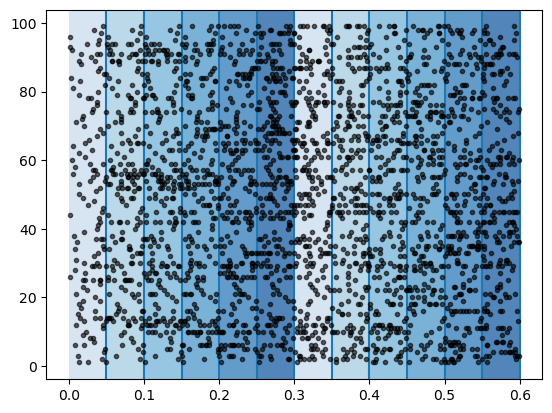

In [6]:
params = {'start_time' : 0.0,
        'end_time' : 0.6,
        'start_index' : 0,
        'end_index' : 100,}

plot_input(times, indices, params)

In [7]:
indices, times, (indices_pattern, times_pattern) = copy_and_paste_jittered_pattern(times, indices, position_copypaste, patternlength, jitter_sd, spike_del,number_pat)
indices_add, times_add = make_input(min_rate_add, max_rate_add, max_time_wo_spike_add,
                                max_change_speed_add, runduration, number_neurons, dt, is_continuous)
times, indices = add_noise(times, indices, times_add, indices_add)
if tripling and runduration > 300:
        times, indices = triple_input_runtime(times, indices)
        position_copypaste = np.concatenate((position_copypaste, position_copypaste, position_copypaste))
# times, indices = remove_close_spikes(times, indices, dt)
indices = indices.astype(int)

# patneurons = range(0, number_pat)
# nonpatneurons = range(number_pat, number_neurons)

In [8]:
def get_dataset():
    spike_train = np.zeros((number_neurons, int(runduration/dt)))
    for time, index in zip(times, indices):
        time = int(time/dt)
        spike_train[index,time] = 1

    ## TODO: Need to change 0.475 to a variable
    weight = np.ones((number_neurons,1)) * 0.475

    return spike_train, weight

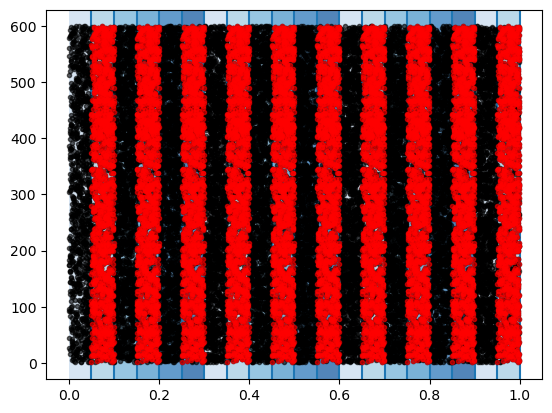

In [9]:
params = {'start_time' : 0.0,
        'end_time' : 1.0,
        'start_index' : 0,
        'end_index' : 600,}

plot_input(times, indices, params, times_pattern, indices_pattern)

In [10]:
class STDP:
    def __init__(self, A_pos, B, tau_pos, tau_neg, verbose=False) -> None:
        """_summary_

        Args:
            A_pos (_type_): _description_
            B (_type_): _description_
            tau_pos (_type_): _description_
            tau_neg (_type_): _description_
        """
        self.A_pos = A_pos
        self.B = B
        self.A_neg = - B * self.A_pos
        self.tau_pos = tau_pos
        self.tau_neg = tau_neg
        self.verbose = verbose

    def plot_stdp_(self, range, stepsize):
        r = np.arange(-range,range, stepsize)
        l = len(r)
        half = int(l/2)
        dw = [self.ltp(val) if val<0 else self.ltd(val) for val in r ]
        # de_neg = [self.ltd(val) if val<0 for val in r]
        plt.plot(r[:half], dw[:half], '.r')
        plt.plot(r[half:], dw[half:], '.b')
        plt.axhline(0, linestyle=':', color='black')
        plt.axvline(0, linestyle=':', color='black')
        plt.xlabel('T_pre - T_post (ms)')
        plt.ylabel('dw')
    
    def ltp(self, delta_t):
        return self.A_pos * np.exp(delta_t/self.tau_pos)

    def ltd(self, delta_t):
        return self.A_neg * np.exp(-delta_t/self.tau_neg)
    
    def do_ltp(self,stdp_window, t, dt):
        spike_row_index = np.nonzero(stdp_window)
        n , window_length = stdp_window.shape
        afferent_last_spike_time = np.full((n, 1), -np.inf)
        afferent_last_spike_time[spike_row_index[0], 0] = spike_row_index[1]
        afferent_last_spike_time *= dt
        delta_t = afferent_last_spike_time - (window_length) * dt
        dw = self.ltp(delta_t)
        return dw 

    def do_ltd(self, n, first_time_spiked, t_j, t_i): 
        dw = np.zeros((n,1))
        if t_i > 0:
            t= t_j - t_i
            ltd_val = self.ltd(delta_t= t)
            dw[list(first_time_spiked),:] = ltd_val
        return dw

In [11]:
class BaseModel:
    def plot_kernel_(self, kernel, range, step_size):
        r = np.arange(0,range,step_size)
        if kernel == 'eta':
            plt.plot(r/self.dt,self.eta_kernel(r), label=r'\eta kernel')
            plt.plot(r/self.dt,self.eta_kernel(r), 'xr')
            plt.axhline(0, linestyle='-', color='black')
            plt.axhline(min(self.eta_kernel(r)), linestyle='-.', color='black', label='minimum vlaue')
            plt.axhline(max(self.eta_kernel(r)), linestyle='-.', color='gray', label='maximum value')
            plt.xlabel(r'$t - t_j$ (ms)')
            plt.ylabel(r'$\eta (t - t_j)$ kernel')
            plt.legend()
            
        elif kernel == 'eps':
            plt.plot(r/self.dt, self.eps_kernel(r), '--k', label=r'$\varepsilon$ kernel')
            plt.plot(r/self.dt,self.eps_kernel(r), 'xr')
            plt.axhline(0, linestyle='-.', color='black', label='minimum vlaue')
            plt.axhline(1, linestyle='-.', color='gray', label='maximum value')
            plt.xlabel(r'$t - t_j$ (ms)')
            plt.ylabel(r'$\varepsilon (t - t_j)$ kernel')
            plt.legend()
        else:
            raise ValueError(f"kernel must be either 'eta' or 'eps' ")
        
    def show_epsilon_matrix_(self, size):
        def print_epsilon_matrix(matrix):
            max_lengths = max([max(len(str(cell)) for cell in row) for row in matrix])
            
            column_widths = [max_lengths+2 for _ in range(matrix.shape[1])]
            for row in matrix:
                print(" ".join(f"{cell:<{width}}" for cell, width in zip(row, column_widths)))
        
        matrix = np.empty((2,size), dtype='U40')

        for i in range(size):
            matrix[0, i] = f'epsilon({size-i}ms)'
            matrix[1, i] = self.eps_kernel((size-i)*self.dt)
            # matrix[0, i] = f'epsilon({size-i-1}ms)'
            # matrix[1, i] = self.eps_kernel((size-i-1)*self.dt)
        print_epsilon_matrix(matrix)
    
    def plot_membrane_potential_(self, spike_train):
        plt.figure(figsize=(9,9))
        plt.plot(np.arange(0,len(self.potential_rec),1), self.potential_rec)
        # spikes = np.where(spike_train ==1)[1]
        # for spk in spikes:
        #     plt.axvline(spk, linestyle='-.', color='gray')
        # if len(self.spike_rec)>0:
        #     for spk in self.spike_rec:
        #         plt.axvline(spk/self.dt, linestyle='--', color='gray')
        plt.axhline(self.threshold, linestyle='dotted', color='orange')
        plt.axhline(0, linestyle='dotted', color='k')
        plt.xlabel('Time (ms)')
        plt.ylabel('Potential (arbitraary units)')


class SRM(BaseModel):
    def __init__(self, threshold, tau_m, tau_s, K1, K2, dt, window_size, tref, verbose, A_pos, B, tau_pos, tau_neg) -> None:
        """_summary_

        Args:
            threshold (_type_): _description_
            tau_m (_type_): _description_
            tau_s (_type_): _description_
            K (_type_): _description_
            K1 (_type_): _description_
            K2 (_type_): _description_
            window_size (_type_): _description_
            verbose (bool, optional): _description_. Defaults to True.
        """
        self.threshold = threshold
        self.tau_m = tau_m
        self.tau_s = tau_s
        self.K1 = K1
        self.K2 = K2
        self.dt = dt
        self.window_size = window_size
        self.tref = tref
        self.verbose = verbose 

        self.A_pos= A_pos
        self.B=B
        self.tau_pos=tau_pos
        self.tau_neg=tau_neg
        self.A_neg = - B * self.A_pos
        
        # initial state of the neuron
        self.last_spike_time = - 10e6 # seocnd
        self.spike_rec = []
        self.potential_rec = [0]
        self.ref_counter = 0
        self.afferents_already_spiked = set()

        ##############
        self.w_sample = None
        ##############

    def do_ltp(self,stdp_window):
        spike_row_index = np.nonzero(stdp_window)
        n , window_length = stdp_window.shape
        afferent_last_spike_time = np.full((n, 1), -np.inf)
        afferent_last_spike_time[spike_row_index[0], 0] = spike_row_index[1]
        afferent_last_spike_time *= self.dt
        delta_t = afferent_last_spike_time - (window_length) * self.dt
        dw = self.ltp(delta_t)
        return dw 

    def do_ltd(self, n, first_time_spiked, t_j):
        """
        self.last_spike_time = t_i
        """ 
        dw = np.zeros((n,1))
        if self.last_spike_time > 0:
            t= t_j - self.last_spike_time
            ltd_val = self.ltd(delta_t= t)
            dw[list(first_time_spiked),:] = ltd_val
        return dw
    
    def ltp(self, delta_t):
        return self.A_pos * np.exp(delta_t/self.tau_pos)

    def ltd(self, delta_t):
        return self.A_neg * np.exp(-delta_t/self.tau_neg)

    def eps_kernel(self, s):
        """"
        s = t - t_j 
        time difference between thre current time and spike time of presynaptic neuron (t_j)
        K is chosen such that the maximum value of epsilon kernel will be 1, based on the tau_m and tau_s.
        """
        s_max = (self.tau_m * self.tau_s) / (self.tau_s - self.tau_m) * np.log(self.tau_s / self.tau_m)
        max_val = (np.exp(-s_max/self.tau_m) - np.exp(-s_max/self.tau_s))
        self.K = 1 / max_val
        return self.K * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
    
    def eta_kernel(self, s):
        positive_pulse = self.K1 * np.exp(-s/self.tau_m)
        negative_spike_afterpotential = self.K2 * (np.exp(-s/self.tau_m) - np.exp(-s/self.tau_s))
        return self.threshold * (positive_pulse - negative_spike_afterpotential)
    
    def create_epsilon_matrix(self, spike_train):
        matrix = np.zeros(spike_train.shape)
        if spike_train.ndim ==1:
            size = len(spike_train)
            for it in np.arange(size):
                matrix[it] = self.eps_kernel((size-it)*self.dt)
        else:
            size = spike_train.shape[1]
            for it in np.arange(size):
                ## TODO: eps(0) not calculated 
                matrix[:, it] = self.eps_kernel((size-it)*self.dt)
        return matrix
    
    def reset_neuron(self):
        self.last_spike_time = - 10e6 # seocnd
        self.spike_rec = []
        self.potential_rec = [0]
        self.ref_counter = 0
        self.afferents_already_spiked = set()
    
    def get_potential(self, spike_train_window, weight, t):
        epsilon_matrix = self.create_epsilon_matrix(spike_train_window)
        eps = spike_train_window * epsilon_matrix
        eps = np.sum(eps, axis=1, keepdims=True)
        eps = eps * weight
        eps = np.sum(eps)
        eta = self.eta_kernel(t+self.dt-self.last_spike_time)
        potential = eta + eps
        return potential

    def get_spike_train_window(self, index, spike_train):
        start_widnow = max(0, index-self.window_size, int((self.last_spike_time)/self.dt))
        end_window = index + 1
        spike_train_window = spike_train[:, start_widnow:end_window]
        return spike_train_window
    
    def get_stdp_window(self, index, spike_train):
        start_widnow = max(0, index-self.window_size, int((self.last_spike_time+self.dt)/self.dt))
        # end_window = index + 1
        end_window = index
        stdp_window = spike_train[:, start_widnow:end_window]
        return stdp_window

    def run(self, spike_train, weight):
        n, total_length = spike_train.shape

        if self.w_sample is None:
            self.w_sample = np.ones((10,total_length)) * 0.475
        
        for it in range(total_length): 
        ##### moved this block out of the for loop #####          
            t = it*self.dt

            if self.ref_counter > 0:
                self.ref_counter -= 1
            elif self.potential_rec[-1] > self.threshold:
                ##### STDP LTP Rule #####
                stdp_window = self.get_stdp_window(index=it, spike_train=spike_train)
                dw = self.do_ltp(stdp_window)
                weight += dw
                ##### limit weights to max 1
                id_temp = weight[:] > 1
                weight[id_temp] = 1
                
                # we spike
                self.last_spike_time = t # ms
                self.spike_rec.append(t) # time in ms
                self.ref_counter = (self.tref)/self.dt
                self.potential_rec[-1] = self.eta_kernel(t-self.last_spike_time)

                self.afferents_already_spiked = set()


            spike_train_window = self.get_spike_train_window(index=it, spike_train=spike_train)

            ## update which afferents has spiked since the last spike of postsynaptic neuron
            # to avoid considering input spikes when t_j = t_i, because t_j has been used already for LTP.
            ## for now ltd_checker is useless,
            if t > self.last_spike_time:
                afferents_spiked_now = set(np.where(spike_train_window[:, -1:] == 1)[0])
            else:
                afferents_spiked_now = set()

            potential = self.get_potential(spike_train_window, weight, t)
            
            self.potential_rec.append(potential)

            ##### STDP LTD Rule #####
            first_time_spiked = afferents_spiked_now - self.afferents_already_spiked
            dw = self.do_ltd(n, first_time_spiked, t)
            weight += dw
            self.last_ltd_vals = dw
            ##### limit weights to min 0
            id_temp = weight[:] < 0
            weight[id_temp] = 0

            self.afferents_already_spiked = self.afferents_already_spiked.union(afferents_spiked_now)
            
            if self.verbose:
                print(f't = {it}ms')
                print('spike_train_window')
                pprint(spike_train_window)
                print(f'epsilon matrix({t+self.dt}ms):')
                pprint(self.create_epsilon_matrix(spike_train_window))
                eta = self.eta_kernel(t+self.dt-self.last_spike_time)
                print(f'eta({t+self.dt}-{self.last_spike_time}) = eta({t+self.dt -self.last_spike_time}) = {eta}')
                print('afferent which is their first time spike')
                print(first_time_spiked)
                print('those neuron which has spiked since last post-synaptic spike')
                print(self.afferents_already_spiked)
                print('spike_rec')
                print(self.spike_rec)
                print(f'potential at {it+1}ms = {potential}')
                pprint(self.potential_rec)
                print(f'//////// end {it}ms ////////\n')

            ##### moved this block out of the for loop #####

            if (it+1)%10000 == 0 :
                print(f'time {t+self.dt} done.')

            self.w_sample[:,it:it+1] = weight[:10,:]
        
        self.spike_rec = np.array(self.spike_rec)
        self.potential_rec = np.array(self.potential_rec)
        self.weight = weight
        return weight

In [12]:
A_pos= 0.03125
B=0.85
tau_pos=0.0168
tau_neg=0.0337
verbose=False

# stdp = STDP(A_pos= A_pos, B=B, tau_pos=tau_pos, tau_neg=tau_neg, verbose=verbose)

A_neg = -B*A_pos
print('B factor is:')
print(-A_neg*tau_neg/(A_pos*tau_pos))


B factor is:
1.7050595238095239


In [13]:
threshold = 500
tau_m = 0.010
tau_s = 0.0025
K1 = 2
K2 = 4
dt = 0.001
window_size = np.inf
tref = 0.001
verbose = False

model = SRM(threshold=threshold, tau_m=tau_m, tau_s=tau_s, K1=K1, K2=K2,
            dt=dt, window_size=window_size, tref=tref, verbose=verbose, 
            A_pos= A_pos, B=B, tau_pos=tau_pos, tau_neg=tau_neg)

In [14]:
# duration = 20 # second
# duration = int(duration/dt) 
spike_train, weight = get_dataset()
# print(spike_train.shape)
# spike_train = spike_train[:, :duration]
# print(spike_train.shape)

In [15]:
def run_simulation(model, spike_train, weight):
    n, total_length = spike_train.shape
    model.reset_neuron()
    # for it in range(total_length):
    weight = model.run(spike_train, weight)

    return model, weight

In [16]:
model, weight = run_simulation(model, spike_train, weight)

time 10.0 done.
time 20.0 done.
time 30.000000000000004 done.


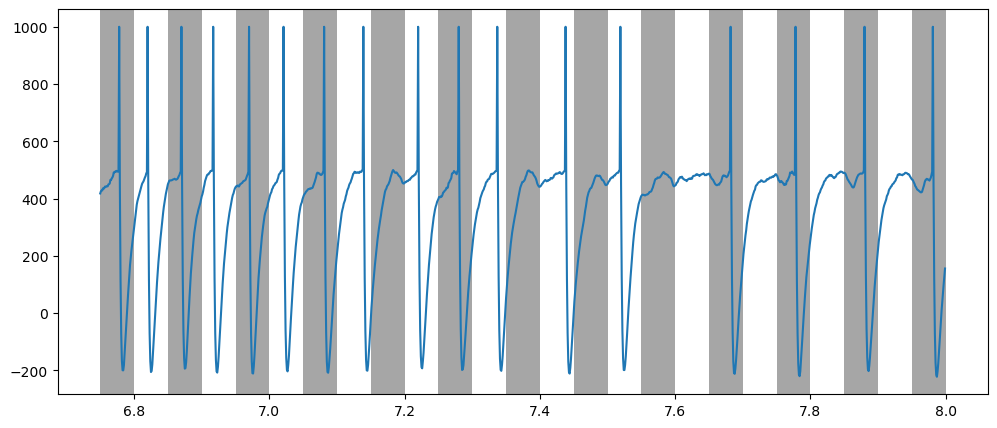

In [24]:
start_time = 6.75
end_time = 8

plt.figure(figsize=(12,5))
plt.plot(np.arange(start_time,end_time,dt), model.potential_rec[int(start_time/dt):int(end_time/dt)])

position_copypaste[int(start_time/patternlength) : int(end_time/patternlength)]
intervals = np.arange(start_time,end_time+patternlength,patternlength)
for i in range(0, len(intervals)-1, 2):
    plt.axvspan(intervals[i], intervals[i + 1], facecolor='gray', alpha=0.7)

# for x in np.arange(start_time,end_time, 0.05):
#     plt.axvline(x, color='red', linestyle='--', alpha=0.3)
plt.show()

In [28]:
# post_spikes = np.zeros((1,duration))
# for spike_time in model.spike_rec:
#     t = int(spike_time / dt)
#     post_spikes[0,t] = 1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0.])

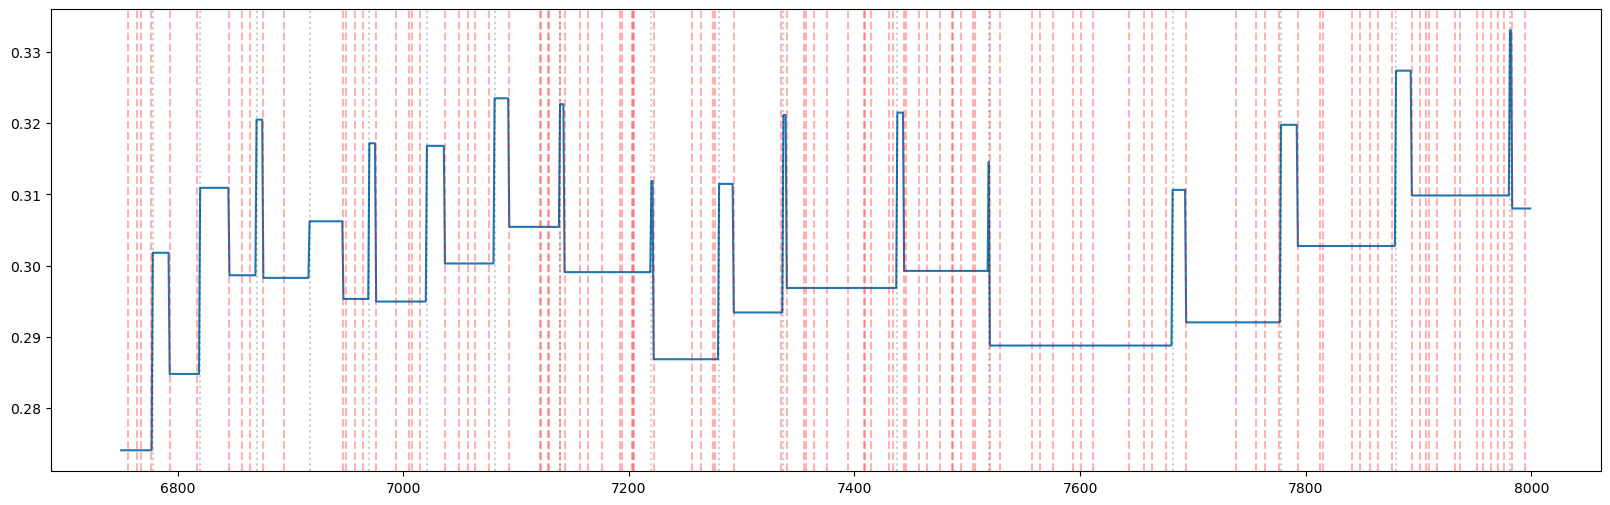

In [26]:
start_time = int(6.75 / dt)
end_time = int(8 / dt)
neuron0 = spike_train[0, start_time:end_time]
r = np.arange(start_time,end_time,1)

plt.figure(figsize=(20,6))
for i in range(1):
    plt.plot(r, model.w_sample[i, start_time:end_time])

for x in np.where(neuron0 == 1)[0]:
    plt.axvline(x+start_time, color='red', linestyle='--', alpha=0.3, label='neuron 0 spike')

for spk in model.spike_rec:
    spk = int(spk/dt)
    if spk > start_time and spk < end_time:
        plt.axvline(spk, color='black', linestyle=':', alpha=0.2)

# for x in model.spike_rec[:20]:
#     plt.axvline(x/dt, color='black', linestyle=':', alpha=0.2, label='postsynaptic spike')

plt.show()

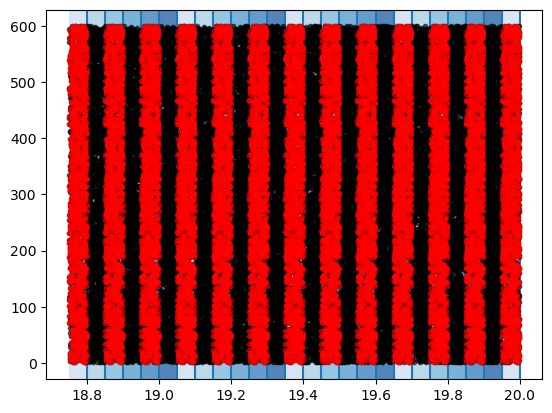

In [100]:
params = {'start_time' : 18.75,
        'end_time' : 20.0,
        'start_index' : 0,
        'end_index' : 600,}

plot_input(times, indices, params, times_pattern, indices_pattern)

In [18]:
model.spike_rec[-1]

149.995

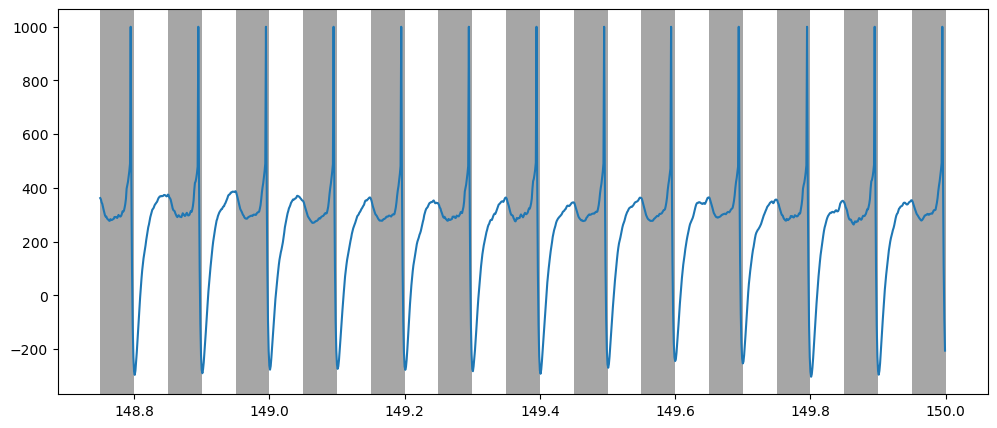

In [28]:
start_time = 148.75
end_time = 150

plt.figure(figsize=(12,5))
plt.plot(np.arange(start_time,end_time,dt), model.potential_rec[int(start_time/dt):int(end_time/dt)])

position_copypaste[int(start_time/patternlength) : int(end_time/patternlength)]
intervals = np.arange(start_time,end_time+patternlength,patternlength)
for i in range(0, len(intervals)-1, 2):
    plt.axvspan(intervals[i], intervals[i + 1], facecolor='gray', alpha=0.7)

# for x in np.arange(start_time,end_time, 0.05):
#     plt.axvline(x, color='red', linestyle='--', alpha=0.3)
plt.show()

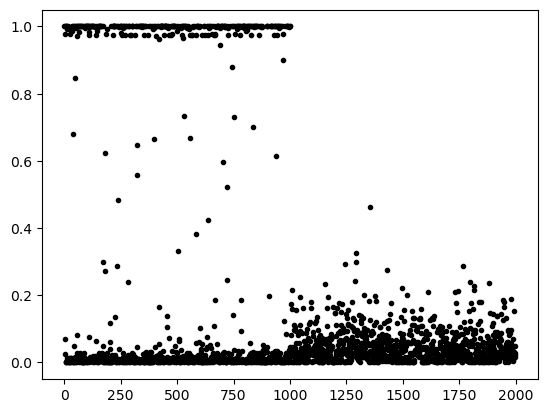

In [22]:
plt.plot(np.arange(len(weight)), weight, '.k')
plt.show()

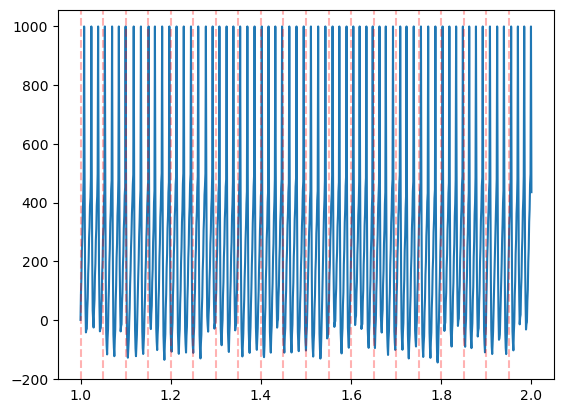

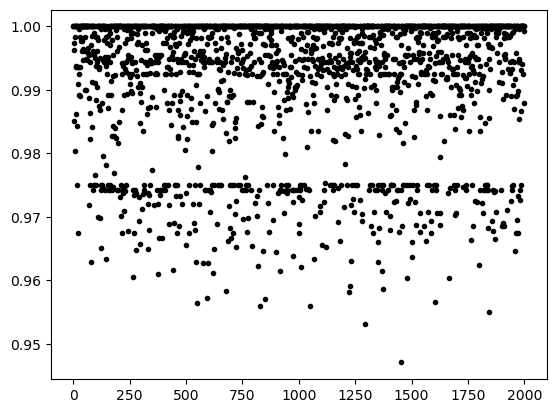

In [40]:
plt.plot(np.arange(1,2.001,0.001), model.potential_rec[1000:2001])
for x in np.arange(1,2, 0.05):
    plt.axvline(x, color='red', linestyle='--', alpha=0.3)
plt.show()

plt.plot(np.arange(len(weight)), weight, '.k')
plt.show()

In [ ]:
# # spike_train = np.array([[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#                         # [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], dtype=int)
# # spike_train = spike_train[:, :9]
# ####### like in the paper fig.3
spike_train = np.zeros((2,75))
spike_train[0, [2,23,44,50,]] = 1
spike_train[1, [45,48,61,   62,63,64,65]] = 1
# # spike_train[0, 2] = 1
# ####################################
weight = np.array([1,1], dtype=float).reshape(-1,1)

model, weight = run_simulation(model, spike_train, weight)

## code from GitHub

In [ ]:
### what the hell is this weight matrix in the network and why it is 17*17 instead of 9*8 (#input neurons * #hidden neurons)!
IN = 9
HN = 8
toatl_neuron = IN + HN
a = np.random.random((IN, HN)) # (9 X 8) Matrix
b = np.zeros((HN, HN)) # (8 X 8) Matrix
w = np.concatenate((a, b), axis=0) # (17 X 8) Matrix
weight = np.zeros((toatl_neuron, IN))
weight = np.concatenate((weight, w), axis=1) # (17 X 17) Matrix
weight = (weight + weight.T) / 2  # symmetric matrix
c, d = weight.shape
print(c, d)
# print(np.array_str(weight, precision=3, suppress_small=True))
pprint(weight)

In [5]:
class SRM:
    """ SRM_0 (Spike Response Model) """
    #def __init__(self, neurons, threshold, t_current, t_membrane, eta_reset, simulation_window_size=100, verbose=False):
    def __init__(self, neurons, threshold=1, t_current=0.3, t_membrane=20, eta_reset=5, simulation_window_size=100, verbose=True):
        """
        Neurons can have different threshold, t_current, t_membrane and eta_resets: Set those variables to 1D np.arrays of all the same size.

        :param neurons: Number of neurons
        :param threshold: Spiking threshold
        :param t_current: Current-time-constant (:math:`t_s`)
        :type t_current: Float or Numpy Float Array
        :param t_membrane: Membrane-time-constant (t_m)
        :param eta_reset: Reset constant
        :param simulation_window_size: Only look at the n last spikes
        :param verbose: Print verbose output to the console
        :return: ``None``
        """

        # Check user input
        try: neurons = int(neurons)
        except: raise ValueError("Variable neurons should be int or convertible to int")

        # threshold, t_current, t_membrane, and eta_reset are all vector
        threshold = np.array(threshold)
        t_current = np.array(t_current)
        t_membrane = np.array(t_membrane)
        eta_reset = np.array(eta_reset)

        if not(threshold.shape == t_current.shape == t_membrane.shape == eta_reset.shape):
            raise ValueError("Vector of threshhold, t_current, t_membrane, and eta_reset must be same size")

        try: simulation_window_size = int(simulation_window_size)
        except: raise ValueError("Variable simulation_window_size should be int or convertible to int")

        self.neurons = neurons
        self.threshold = threshold
        self.t_current = t_current
        self.t_membrane = t_membrane
        self.eta_reset = eta_reset
        self.simulation_window_size = simulation_window_size
        self.verbose = verbose
        self.cache = {}
        self.cache['last_t'] = -1
        self.cache['last_spike'] = np.ones(self.neurons, dtype=float) * -1000000
        self.cache['last_potential'] = np.zeros(self.neurons, dtype=float)

    def eta(self, s):
        r"""
        Evaluate the Eta function:

        .. math:: \eta (s) = - \eta_{reset} * \exp(\frac{- s}{\tau_m})
            :label: eta

        :param s: Time s
        :return: Function eta(s) at time s
        :return type: Float or Vector of Floats
        """

        return - self.eta_reset*np.exp(-s/self.t_membrane)

    def eps(self, s):
        r"""
        Evaluate the Epsilon function:

        .. math:: \epsilon (s) =  \frac{1}{1 - \frac{\tau_c}{\tau_m}} (\exp(\frac{-s}{\tau_m}) - \exp(\frac{-s}{\tau_c}))
            :label: epsilon

        Returns a single Float Value if the time constants (current, membrane) are the same for each neuron.
        Returns a Float Vector with eps(s) for each neuron, if the time constants are different for each neuron.

        :param s: Time s
        :return: Function eps(s) at time s
        :rtype: Float or Vector of Floats
        """
        return (1/(1-self.t_current/self.t_membrane))*(np.exp(-s/self.t_membrane) - np.exp(-s/self.t_current))

    def eps_matrix(self, k, size):
        """

        Returns the epsilon helpermatrix.

        :Example:

        #>>> eps_matrix(3,5)

        [[eps_0(3), eps_0(2), eps_0(1), eps_0(0), eps_0(0)],
         [eps_1(3), eps_1(2), eps_1(1), eps_1(0), eps_1(0)]]

        Where `eps_0(3)` means the epsilon function of neuron 0 at time 3.

        :param k: Leftmost epsilon time
        :param size: Width of the return matrix
        :return: Epsilon helper matrix
        :return type: Numpy Float Array, dimensions: (neurons x size)
        """

        matrix = np.zeros((self.neurons, size), dtype=float)

        for i in range(k):
            matrix[:, i] = self.eps(k-i)

        return matrix

    def check_spikes(self, spiketrain, weights, t, additional_term=None):
        """
        Simulate one time step at time t. Changes the spiketrain in place at time t!
        Return the total membrane potential of all neurons.

        :param spiketrain: Spiketrain (Time indexing begins with 0)
        :param weights: Weights
        :param t: Evaluation time
        :param additional_term: Additional potential that gets added before we check for spikes (For example for extern voltage)
        :return: total membrane potential of all neurons at time step t (vector), spikes at time t
        """

        # Check correct user input

        if type(spiketrain) != np.ndarray:
            raise ValueError("Spiketrain should be a numpy array")

        if type(weights) != np.ndarray:
            raise ValueError("Weights should be a numpy matrix")

        if additional_term != None and type(additional_term) != np.ndarray:
            raise ValueError("Additional_term should be a numpy array")

        try: t = int(t)
        except: raise ValueError("Variable t should be int or convertible to int")

        if t < 0:
            raise ValueError("Time to be simulated is too small")

        if t >= spiketrain.shape[1]:         #spiketrain.shape[1] 'return no of column in each row '
            raise ValueError("Spiketrain too short (0ms -- %dms) for simulating time %d" % (spiketrain.shape[1]-1, t))

        if weights.shape[0] != self.neurons or self.neurons != weights.shape[1]:
            raise ValueError("Weigths should be a quadratic matrix, with one row and one column for each neuron")

        if spiketrain.shape[0] != self.neurons:
            raise ValueError("Spikes should be a matrix, with one row for each neuron")

        if additional_term != None and additional_term.shape[0] != self.neurons:
            raise ValueError("Additional_term should be a vector with one element for each neuron")

        if additional_term != None and len(additional_term) == 2 and additional_term.shape[1] != 1:
            raise ValueError("Additional_term should be a vector with one element for each neuron")

        # Work on a windowed view
        spiketrain_window = spiketrain[:, max(0, t+1-self.simulation_window_size):t+1]

        # Retrieve necessary simulation data from cache if possible
        if self.cache['last_t'] == -1 or self.cache['last_t'] == t - 1:
            last_spike = self.cache['last_spike']
            last_potential = self.cache['last_potential']
        else:
            last_spike = t - np.argmax(spiketrain_window[:, ::-1], axis=1)
            # TODO find a way to calculate last_potential (recursive call to check_spikes is not a good option)
            last_potential = np.zeros(self.neurons)

        neurons, timesteps = spiketrain_window.shape

        epsilon_matrix = self.eps_matrix(min(self.simulation_window_size, t), timesteps)

        # Calculate current
        incoming_spikes = np.dot(weights.T, spiketrain_window)
        incoming_potential = np.sum(incoming_spikes * epsilon_matrix, axis=1)
        total_potential = self.eta(np.ones(neurons)*t - last_spike) + incoming_potential
        # Calculate current end

        # Add additional term (user-defined)
        if additional_term != None:
            total_potential += additional_term

        # Any new spikes? Only spike if potential hits the threshold from below.
        neurons_high_current = np.where((total_potential > self.threshold) & (last_potential < self.threshold))
        spiketrain[neurons_high_current, t] = True

        # Update cache (last_spike, last_potential and last_t)
        spiking_neurons = np.where(spiketrain[:, t])
        self.cache['last_spike'][spiking_neurons] = t
        self.cache['last_potential'] = total_potential
        self.cache['last_t'] = t

        if self.verbose:
            print("SRM Time step", t)
            print("Incoming current", incoming_potential)
            print("Total potential", total_potential)
            print("Last spike", last_spike)
            print("")

        return total_potential

class SRM_X(SRM):
    def __init__(self, neurons, threshold, t_current, t_membrane, eta_reset, ax_delay, simulation_window_size=100, verbose=False):
        """
        Like the SRM model, but additionally it supports axonal delays.

        :param neurons: Number of neurons
        :param threshold: Spiking threshold
        :param t_current: Current-time-constant (:math:`t_s`)
        :type t_current: Float or Numpy Float Array
        :param t_membrane: Membrane-time-constant (t_m)
        :param eta_reset: Reset constant
        :param ax_delay: Axonal delays
        :param simulation_window_size: Only look at the n last spikes
        :param verbose:
        :return: ``None``
        """

        # Check user input
        # TODO

        SRM.__init__(self, neurons, threshold, t_current, t_membrane, eta_reset, simulation_window_size=simulation_window_size,
                     verbose=verbose)

        self.ax_delay = ax_delay

    def eps(self, s):
        r"""
        Evaluate the Epsilon function with an axonal delay :math:`\tau_d`.

        .. math:: \epsilon (s) =  \frac{1}{1 - \frac{\tau_c}{\tau_m}} (\exp(\frac{-(s-\tau_d)}{\tau_m}) - \exp(\frac{-(s - \tau_d)}{\tau_c}))
            :label: epsilon_axdelay

        Returns a single Float Value if the time constants (current, membrane) are the same for each neuron.
        Returns a Float Vector with eps(s) for each neuron, if the time constants are different for each neuron.

        :param s: Time s
        :return: Function eps(s) at time s
        :rtype: Float or Vector of Floats
        """
        eps = (1/(1-self.t_current/self.t_membrane))*(np.exp(-(s - self.ax_delay)/self.t_membrane)
                                                       - np.exp(- (s - self.ax_delay)/self.t_current))

        eps[np.where(eps<0)] = 0
        return eps

if __name__ == "__main__":

    srm_model = SRM(neurons=3, threshold=1, t_current=0.3, t_membrane=20, eta_reset=5, verbose=True)

    models = [srm_model]

    for model in models:
        print("-"*10)
        if isinstance(model, SRM):
            print('Demonstration of the SRM Model')

        s = np.array([[0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
                      [1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

        #w = np.array([[0, 0, 3.8], [0, 0, 1.78], [0, 0, 0]])
        w = np.array([[0, 0, 1], [0, 0, 1], [0, 0, 0]])
        #w = np.random.random((3,3))
        neurons, timesteps = s.shape

        for t in range(timesteps):
            total_current = model.check_spikes(s, w, t)
            print("Spiketrain:\n", s)

----------
Demonstration of the SRM Model
SRM Time step 0
Incoming current [0. 0. 0.]
Total potential [0. 0. 0.]
Last spike [-1000000.        0. -1000000.]

Spiketrain:
 [[0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
SRM Time step 1
Incoming current [0.        0.        0.9294979]
Total potential [ 0.         -4.75614712  0.9294979 ]
Last spike [-1000000.        0. -1000000.]

Spiketrain:
 [[0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
SRM Time step 2
Incoming current [0.         0.         0.91732465]
Total potential [ 0.         -4.52418709  0.91732465]
Last spike [ 2.e+00  0.e+00 -1.e+06]

Spiketrain:
 [[0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
SRM Time step 3
Incoming current [0.         0.         1.80326701]
Total potential [-4.75614712 -4.30353988  1.80326701]
Last spike [2. 0. 3.]

Spiketrain:
 [[0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
SRM Time step 4
Incoming current [0.       

In [8]:
s = np.array([[0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
                      [1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

wind = s[:, 0:0+1]

wind, np.dot(w.T, wind)

(array([[0],
        [1],
        [0]]),
 array([[0],
        [0],
        [1]]))